# clone + import + drive + paths


In [1]:
import os
run_in_colab = True

In [2]:
config = {
    'beta1' : 0.9,
    'beta2' : 0.999,
    'adverserial_D' : 2e-5,
    'adverserial_M' : 5e-6,
    'non_adverserial_lr' : 5e-5,
    'lrAttr' : 0.0001,
    'IdDiffersAttrTrainRatio' : 3, # 1/3
    'batchSize' : 4,
    'R1Param' : 10,
    'lambdaID' : 1,
    'lambdaLND' : 1,
    'lambdaREC' : 0.001,
    'a' : 0.84,
    'train_precentege' : 0.93,
    'epochs' : 10
}
GENERATOR_IMAGE_SIZE = 1024

In [3]:
def get_base_path(run_in_colab):
    return '/content/drive/MyDrive/CNN-project-weights/' if run_in_colab else '/disk2/danielroich/yotam_disentanglement/Data/'

In [4]:
BASE_PATH = get_base_path(run_in_colab)

MOBILE_FACE_NET_WEIGHTS_PATH = BASE_PATH + 'mobilefacenet_model_best.pth.tar'
GENERATOR_WEIGHTS_PATH = BASE_PATH + 'stylegan2-ffhq-config-f.pt'
E_ID_WEIGHTS_PATH = BASE_PATH + 'resnet50_scratch_dag.pth'
IMAGE_DATA_DIR = BASE_PATH + 'fake/image/'
W_DATA_DIR = BASE_PATH + 'fake/w/'
MODELS_DIR = BASE_PATH + 'Models/'

In [5]:
def prepeare_env_for_local_use():
    CUDA_VISIBLE_DEVICES = '4'
    os.chdir('..')
    os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
    os.environ['CUDA_VISIBLE_DEVICES']= CUDA_VISIBLE_DEVICES

In [6]:
def prepeare_env_for_colab():
  !pip install wandb
  from google.colab import drive
  drive.mount('/content/drive')
  os.chdir('/content')
  !pip install pytorch-msssim
  !git clone https://github.com/danielroich/Face-Identity-Disentanglement-via-StyleGan2.git 'project'
  CODE_DIR = 'project'
  os.chdir(f'./{CODE_DIR}')

In [7]:
if run_in_colab:
    prepeare_env_for_colab()
else:
    prepeare_env_for_local_use()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path 'project' already exists and is not an empty directory.


In [8]:
import wandb

wandb.login()

wandb: Currently logged in as: daniel_roich (use `wandb login --relogin` to force relogin)


True

In [9]:
from Losses.AdversarialLoss import calc_Dw_loss
from Models.Encoders.ID_Encoder import resnet50_scratch_dag
from Models.Encoders.Attribute_Encoder import Encoder_Attribute
from Models.Encoders.Landmark_Encoder import Landmark_Encoder
from Models.Discrimanator import Discriminator
from Models.LatentMapper import LatentMapper
from Losses.NonAdversarialLoss import id_loss,landmark_loss,rec_loss
from Models.StyleGan2.model import Generator
from Utils.data_utils import get_w_image, plot_single_w_image, get_w_by_index, WDataSet, ConcatDataset, make_concat_loaders, cycle_images_to_create_diff_order
from Training.trainer import Trainer
from torch.utils.data import DataLoader,random_split
from tqdm import tqdm
import time
import torch
import torch.nn as nn
import torch.utils.data
import torchvision.datasets as dset
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import seaborn as sns
sns.set()

# network + data


In [10]:
id_encoder = resnet50_scratch_dag(E_ID_WEIGHTS_PATH)
attr_encoder = Encoder_Attribute(pretrained=True)
discriminator = Discriminator(512)
mlp = LatentMapper(4096)
landmark_encoder = Landmark_Encoder.Encoder_Landmarks(MOBILE_FACE_NET_WEIGHTS_PATH)
generator = Generator(GENERATOR_IMAGE_SIZE,512,8)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [11]:
state_dict = torch.load(GENERATOR_WEIGHTS_PATH)
generator.load_state_dict(state_dict['g_ema'], strict=False)

<All keys matched successfully>

In [12]:
ID_IMAGE_SIZE = id_encoder.meta['imageSize'][1]
ID_BATCH_MEAN = np.asarray(id_encoder.meta['mean']) / 255
ID_BATCH_STD = np.asarray(id_encoder.meta['std']) / 255
ATTR_IMAGE_SIZE = attr_encoder.meta['imageSize'][1]
ATTR_BATCH_MEAN = np.asarray(attr_encoder.meta['mean'])
ATTR_BATCH_STD = np.asarray(attr_encoder.meta['std'])
LANDMARK_IMAGE_SIZE = 112

In [13]:
# if len(CUDA_VISIBLE_DEVICES) > 1:
#     id_encoder = nn.DataParallel(id_encoder)
#     attr_encoder = nn.DataParallel(attr_encoder)
#     discriminator = nn.DataParallel(discriminator)
#     mlp = nn.DataParallel(mlp)
#     generator = nn.DataParallel(generator)

In [14]:
id_encoder = id_encoder.cuda()
attr_encoder = attr_encoder.cuda()
discriminator = discriminator.cuda()
mlp = mlp.cuda()
generator = generator.cuda()
landmark_encoder = landmark_encoder.cuda()

In [15]:
id_encoder = id_encoder.eval()
attr_encoder = attr_encoder.eval()
discriminator = discriminator.train()
generator = generator.train()
mlp = mlp.train()
landmark_encoder = landmark_encoder.eval()

In [16]:
id_transform=transforms.Compose([
                                transforms.Resize(ID_IMAGE_SIZE),
                                transforms.CenterCrop(ID_IMAGE_SIZE),
                                transforms.Normalize(ID_BATCH_MEAN, ID_BATCH_STD)
                                ])

attr_transform=transforms.Compose([
                                transforms.Resize(ATTR_IMAGE_SIZE),
                                transforms.CenterCrop(ATTR_IMAGE_SIZE),
                                transforms.Normalize(ATTR_BATCH_MEAN, ATTR_BATCH_STD)
                                ])

landmark_transform=transforms.Compose([transforms.Resize(LANDMARK_IMAGE_SIZE)])

In [17]:
data_dir = IMAGE_DATA_DIR

attr_dataset = dset.ImageFolder(root=data_dir, transform= transforms.ToTensor())
id_dataset = dset.ImageFolder(root=data_dir, transform= transforms.ToTensor())
w_dataset = WDataSet(W_DATA_DIR)

In [18]:
full_dataset = ConcatDataset((id_dataset, attr_dataset,w_dataset))
train_size = int(config['train_precentege'] * len(full_dataset))
test_size = len(full_dataset) - train_size
train_data, test_data = random_split(full_dataset, [train_size, test_size])

In [19]:
train_loader = DataLoader(dataset=train_data, batch_size=config['batchSize'], shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=config['batchSize'], shuffle=True)

# Training

In [20]:
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=config['adverserial_D'], betas=(config['beta1'], config['beta2']))
optimizer_adv_M = torch.optim.Adam(mlp.parameters(), lr=config['adverserial_M'], betas=(config['beta1'], config['beta2']))
optimizer_non_adv_M = torch.optim.Adam(mlp.parameters(), lr=config['non_adverserial_lr'], betas=(config['beta1'], config['beta2']))

In [21]:
trainer = Trainer(config, optimizer_D, optimizer_adv_M,optimizer_non_adv_M,discriminator,generator,
                  id_transform, attr_transform,landmark_transform, id_encoder, attr_encoder, landmark_encoder)

In [22]:
run = wandb.init(project="disantalgement_stylegan", reinit=True, config = config)

In [23]:
id_images, attr_images, ws = next(iter((test_loader)))

id_images = id_images[0].cuda()
attr_images = attr_images[0].cuda()
cycled_attr_images = cycle_images_to_create_diff_order(attr_images).clone()
non_cycled_attr_images = attr_images.clone()
ws = ws.cuda()

with torch.no_grad():
    id_vec = torch.squeeze(id_encoder(id_transform(id_images)))
    non_cycled_attr_vec = torch.squeeze(attr_encoder(attr_transform(non_cycled_attr_images)))
    cycled_attr_vec = torch.squeeze(attr_encoder(attr_transform(cycled_attr_images)))
    non_cycled_test_vec = torch.cat((id_vec,non_cycled_attr_vec), dim=1)
    cycled_test_vec = torch.cat((id_vec,cycled_attr_vec), dim=1)

/content/project/Models/Encoders/ID_Encoder.py:206: UserWarning: This overload of add is deprecated:
	add(Tensor input, Number alpha, Tensor other, *, Tensor out)
Consider using one of the following signatures instead:
	add(Tensor input, Tensor other, *, Number alpha, Tensor out) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  conv2_1 = torch.add(conv2_1_1x1_proj_bn, 1, conv2_1_1x1_increase_bn)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


For index 0 in test_vec we have the following input:
ID image:


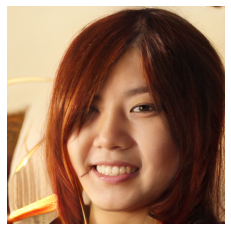

In [24]:
print('For index 0 in test_vec we have the following input:')

with torch.no_grad():
    image1 = get_w_image(ws[0], generator)
    image2 = get_w_image(ws[config['batchSize'] - 1], generator)

    if run_in_colab:
      print('ID image:')
      plot_single_w_image(ws[0], generator)
      print('Attr image:')
      plot_single_w_image(ws[config['batchSize'] - 1], generator)

    wandb.log({"Test_ID_Image": [wandb.Image(image1, caption="ID image")]}, step = 0)
    wandb.log({"Test_Attr_Image": [wandb.Image(image2, caption="Attr image")]}, step = 0)


## Global Training

In [25]:
def mean(tensors_list):
  if len(tensors_list) == 0:
    return 0
  return sum(tensors_list) / len(tensors_list)

In [26]:
D_error_real_train = []
D_error_fake_train = []           
D_prediction_real_train = []
D_prediction_fake_train = []          
G_error_train = []
G_pred_train = []
id_loss_train = []
rec_loss_train = []
landmark_loss_train = []
total_error_train = []

  0%|          | 1/9768 [00:02<8:07:22,  2.99s/it]

rec loss val: 56593.98828125


  0%|          | 2/9768 [00:06<8:18:28,  3.06s/it]

rec loss val: 2617.8291015625


  0%|          | 3/9768 [00:09<8:29:11,  3.13s/it]

rec loss val: 2956.706298828125


  0%|          | 4/9768 [00:12<8:39:43,  3.19s/it]

rec loss val: 5310.8369140625


  0%|          | 5/9768 [00:16<8:39:37,  3.19s/it]

rec loss val: 2440.803466796875


  0%|          | 6/9768 [00:19<8:53:24,  3.28s/it]

rec loss val: 2019.357421875


  0%|          | 7/9768 [00:22<8:52:36,  3.27s/it]

rec loss val: 2002.723876953125


  0%|          | 8/9768 [00:26<8:53:21,  3.28s/it]

rec loss val: 2142.528076171875


  0%|          | 9/9768 [00:29<8:57:54,  3.31s/it]

rec loss val: 1883.421630859375


  0%|          | 10/9768 [00:32<8:55:12,  3.29s/it]

rec loss val: 1972.55029296875


  0%|          | 11/9768 [00:35<8:53:46,  3.28s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


rec loss val: 1526.447265625


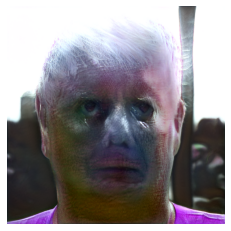

rec loss val: 1526.447265625


  0%|          | 12/9768 [00:39<9:09:38,  3.38s/it]

rec loss val: 2125.99462890625


  0%|          | 13/9768 [00:42<9:11:33,  3.39s/it]

rec loss val: 1666.76025390625


  0%|          | 14/9768 [00:46<9:06:30,  3.36s/it]

rec loss val: 1823.7210693359375


  0%|          | 15/9768 [00:49<8:46:31,  3.24s/it]

rec loss val: 1682.051513671875


  0%|          | 16/9768 [00:52<8:48:53,  3.25s/it]

rec loss val: 1569.3114013671875


  0%|          | 17/9768 [00:55<8:33:28,  3.16s/it]

rec loss val: 1486.2467041015625


  0%|          | 18/9768 [00:59<8:52:38,  3.28s/it]

rec loss val: 1344.9666748046875


  0%|          | 19/9768 [01:02<8:51:02,  3.27s/it]

rec loss val: 1635.4696044921875


  0%|          | 20/9768 [01:05<8:58:59,  3.32s/it]

rec loss val: 1554.9560546875


  0%|          | 21/9768 [01:08<8:38:03,  3.19s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


rec loss val: 1592.636962890625


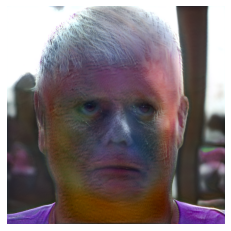

rec loss val: 1592.636962890625


  0%|          | 22/9768 [01:12<8:58:41,  3.32s/it]

rec loss val: 1229.468017578125


  0%|          | 23/9768 [01:15<8:48:20,  3.25s/it]

rec loss val: 1714.33056640625


  0%|          | 24/9768 [01:18<8:52:45,  3.28s/it]

rec loss val: 1488.340087890625


  0%|          | 25/9768 [01:21<8:49:27,  3.26s/it]

rec loss val: 1659.860595703125


  0%|          | 26/9768 [01:25<8:46:49,  3.24s/it]

rec loss val: 1514.0635986328125


  0%|          | 27/9768 [01:28<9:00:12,  3.33s/it]

rec loss val: 1343.6585693359375


  0%|          | 28/9768 [01:32<9:05:30,  3.36s/it]

rec loss val: 1404.693359375


  0%|          | 29/9768 [01:35<9:01:37,  3.34s/it]

rec loss val: 1292.082275390625


  0%|          | 30/9768 [01:38<9:07:37,  3.37s/it]

rec loss val: 1337.7674560546875


  0%|          | 31/9768 [01:42<9:08:14,  3.38s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


rec loss val: 1319.3367919921875


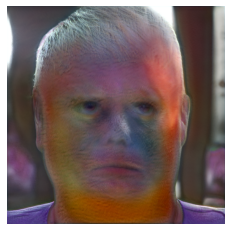

rec loss val: 1319.3367919921875


  0%|          | 32/9768 [01:45<9:06:07,  3.37s/it]

rec loss val: 1435.958251953125


  0%|          | 33/9768 [01:48<9:05:01,  3.36s/it]

rec loss val: 1489.78369140625


  0%|          | 34/9768 [01:51<8:41:02,  3.21s/it]

rec loss val: 1661.6741943359375


  0%|          | 35/9768 [01:54<8:22:57,  3.10s/it]

rec loss val: 1089.5093994140625


  0%|          | 36/9768 [01:58<8:42:34,  3.22s/it]

rec loss val: 1301.6575927734375


  0%|          | 37/9768 [02:01<8:42:57,  3.22s/it]

rec loss val: 1245.69189453125


  0%|          | 38/9768 [02:04<8:46:10,  3.24s/it]

rec loss val: 1289.1883544921875


  0%|          | 39/9768 [02:07<8:43:33,  3.23s/it]

rec loss val: 1398.8665771484375


  0%|          | 40/9768 [02:11<8:50:46,  3.27s/it]

rec loss val: 1214.5272216796875


  0%|          | 41/9768 [02:14<9:01:54,  3.34s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


rec loss val: 1379.0537109375


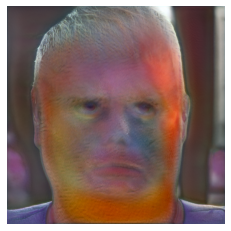

rec loss val: 1379.0537109375


  0%|          | 42/9768 [02:17<8:59:42,  3.33s/it]

rec loss val: 1355.9442138671875


  0%|          | 43/9768 [02:20<8:40:38,  3.21s/it]

rec loss val: 1213.2081298828125


  0%|          | 44/9768 [02:23<8:16:56,  3.07s/it]

rec loss val: 1215.464599609375


  0%|          | 45/9768 [02:26<8:31:25,  3.16s/it]

rec loss val: 1246.4176025390625


  0%|          | 46/9768 [02:30<8:42:38,  3.23s/it]

rec loss val: 1207.970947265625


  0%|          | 47/9768 [02:33<8:43:57,  3.23s/it]

rec loss val: 1201.8060302734375


  0%|          | 48/9768 [02:37<9:03:26,  3.35s/it]

rec loss val: 1349.334228515625


  1%|          | 49/9768 [02:40<8:58:36,  3.33s/it]

rec loss val: 1330.7919921875


  1%|          | 50/9768 [02:43<8:42:39,  3.23s/it]

rec loss val: 1434.33544921875


  1%|          | 51/9768 [02:46<8:26:33,  3.13s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


rec loss val: 1243.294189453125


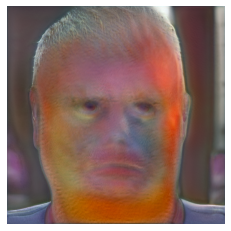

rec loss val: 1243.294189453125


  1%|          | 52/9768 [02:48<7:52:05,  2.92s/it]

rec loss val: 1092.160888671875


  1%|          | 53/9768 [02:51<7:47:40,  2.89s/it]

rec loss val: 1379.7496337890625


  1%|          | 54/9768 [02:54<7:53:25,  2.92s/it]

rec loss val: 1353.5128173828125


  1%|          | 55/9768 [02:58<8:27:50,  3.14s/it]

rec loss val: 1405.9422607421875


  1%|          | 56/9768 [03:01<8:19:04,  3.08s/it]

rec loss val: 1263.5150146484375


  1%|          | 57/9768 [03:03<7:55:36,  2.94s/it]

rec loss val: 1158.404296875


  1%|          | 58/9768 [03:07<8:27:43,  3.14s/it]

rec loss val: 1340.13623046875


  1%|          | 59/9768 [03:10<8:19:44,  3.09s/it]

rec loss val: 1188.55859375


  1%|          | 60/9768 [03:13<8:26:35,  3.13s/it]

rec loss val: 1080.3917236328125


  1%|          | 61/9768 [03:16<8:21:27,  3.10s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


rec loss val: 1162.2208251953125


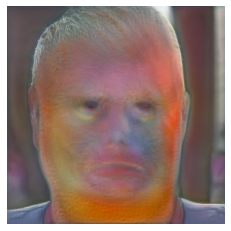

rec loss val: 1162.2208251953125


  1%|          | 62/9768 [03:20<8:51:53,  3.29s/it]

rec loss val: 1135.2152099609375


  1%|          | 63/9768 [03:23<9:00:58,  3.34s/it]

rec loss val: 1161.257080078125


  1%|          | 64/9768 [03:27<9:01:36,  3.35s/it]

rec loss val: 1233.2430419921875


  1%|          | 65/9768 [03:30<8:54:38,  3.31s/it]

rec loss val: 1207.417724609375


  1%|          | 66/9768 [03:33<8:18:19,  3.08s/it]

rec loss val: 1368.0855712890625


  1%|          | 67/9768 [03:36<8:17:55,  3.08s/it]

rec loss val: 1199.1827392578125


  1%|          | 68/9768 [03:39<8:32:43,  3.17s/it]

rec loss val: 1308.9371337890625


  1%|          | 69/9768 [03:42<8:14:51,  3.06s/it]

rec loss val: 1154.1822509765625


  1%|          | 70/9768 [03:45<8:29:06,  3.15s/it]

rec loss val: 1374.931640625


  1%|          | 71/9768 [03:48<8:39:17,  3.21s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


rec loss val: 1038.2982177734375


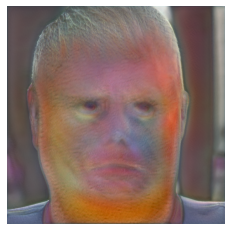

rec loss val: 1038.2982177734375


  1%|          | 72/9768 [03:52<9:08:34,  3.39s/it]

rec loss val: 1069.3214111328125


  1%|          | 73/9768 [03:56<9:12:10,  3.42s/it]

rec loss val: 1262.813232421875


  1%|          | 74/9768 [03:59<9:03:55,  3.37s/it]

rec loss val: 1080.9820556640625


  1%|          | 75/9768 [04:02<8:54:41,  3.31s/it]

rec loss val: 1391.412109375


  1%|          | 76/9768 [04:05<8:31:55,  3.17s/it]

rec loss val: 1088.0726318359375


  1%|          | 77/9768 [04:08<8:19:43,  3.09s/it]

rec loss val: 1341.888671875


  1%|          | 78/9768 [04:11<8:33:07,  3.18s/it]

rec loss val: 1118.38525390625


  1%|          | 79/9768 [04:15<8:37:49,  3.21s/it]

rec loss val: 1475.166015625


  1%|          | 80/9768 [04:17<8:08:08,  3.02s/it]

rec loss val: 1151.014892578125


  1%|          | 81/9768 [04:20<8:08:14,  3.02s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


rec loss val: 1253.5301513671875


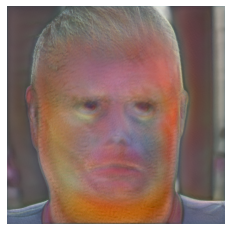

rec loss val: 1253.5301513671875


  1%|          | 82/9768 [04:24<8:51:17,  3.29s/it]

rec loss val: 1083.0928955078125


  1%|          | 83/9768 [04:27<8:47:37,  3.27s/it]

rec loss val: 1054.6676025390625


  1%|          | 84/9768 [04:30<8:30:16,  3.16s/it]

rec loss val: 1244.834228515625


  1%|          | 85/9768 [04:33<8:28:50,  3.15s/it]

rec loss val: 1295.3231201171875


  1%|          | 86/9768 [04:37<8:36:03,  3.20s/it]

rec loss val: 1270.7193603515625


  1%|          | 87/9768 [04:40<8:34:15,  3.19s/it]

rec loss val: 1533.70703125


  1%|          | 88/9768 [04:43<8:37:10,  3.21s/it]

rec loss val: 1138.240478515625


  1%|          | 89/9768 [04:46<8:38:38,  3.22s/it]

rec loss val: 1062.53173828125


  1%|          | 90/9768 [04:50<8:41:30,  3.23s/it]

rec loss val: 1308.44775390625


  1%|          | 91/9768 [04:53<8:36:25,  3.20s/it]

rec loss val: 1207.3843994140625


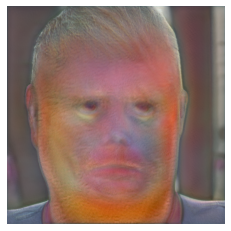

rec loss val: 1207.3843994140625


  1%|          | 92/9768 [04:57<9:12:39,  3.43s/it]

rec loss val: 1134.2520751953125


  1%|          | 93/9768 [05:00<8:56:25,  3.33s/it]

rec loss val: 1266.4815673828125


  1%|          | 94/9768 [05:03<9:07:48,  3.40s/it]

rec loss val: 1163.433837890625


  1%|          | 95/9768 [05:06<8:47:27,  3.27s/it]

rec loss val: 1122.2791748046875


  1%|          | 96/9768 [05:09<8:31:32,  3.17s/it]

rec loss val: 1196.28955078125


  1%|          | 97/9768 [05:13<8:33:34,  3.19s/it]

rec loss val: 1252.765380859375


  1%|          | 98/9768 [05:16<8:41:34,  3.24s/it]

rec loss val: 1123.3485107421875


  1%|          | 99/9768 [05:19<8:44:25,  3.25s/it]

rec loss val: 1275.58544921875


  1%|          | 100/9768 [05:22<8:38:45,  3.22s/it]

rec loss val: 1168.496337890625


  1%|          | 101/9768 [05:25<8:36:16,  3.20s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


rec loss val: 1156.2813720703125


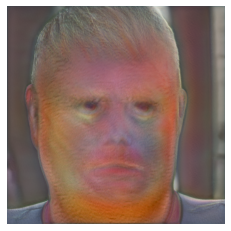

rec loss val: 1156.2813720703125


  1%|          | 102/9768 [05:29<9:00:55,  3.36s/it]

rec loss val: 1059.8389892578125


  1%|          | 103/9768 [05:32<8:54:51,  3.32s/it]

rec loss val: 1267.490234375


  1%|          | 104/9768 [05:36<8:53:43,  3.31s/it]

rec loss val: 913.610595703125


  1%|          | 105/9768 [05:39<8:30:17,  3.17s/it]

rec loss val: 1132.1204833984375


  1%|          | 106/9768 [05:42<8:35:36,  3.20s/it]

rec loss val: 1218.7806396484375


  1%|          | 107/9768 [05:45<8:35:44,  3.20s/it]

rec loss val: 1393.575439453125


  1%|          | 108/9768 [05:48<8:41:17,  3.24s/it]

rec loss val: 1017.759765625


  1%|          | 109/9768 [05:51<8:19:12,  3.10s/it]

rec loss val: 1156.1800537109375


  1%|          | 110/9768 [05:54<8:25:26,  3.14s/it]

rec loss val: 1206.65478515625


  1%|          | 111/9768 [05:58<8:41:13,  3.24s/it]

rec loss val: 1115.06640625


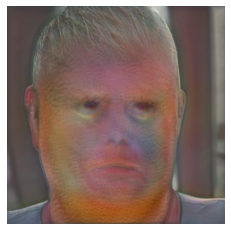

rec loss val: 1115.06640625


  1%|          | 112/9768 [06:02<9:12:29,  3.43s/it]

rec loss val: 1124.435546875


  1%|          | 113/9768 [06:05<8:47:31,  3.28s/it]

rec loss val: 1039.84765625


  1%|          | 114/9768 [06:08<8:53:33,  3.32s/it]

rec loss val: 1154.861572265625


  1%|          | 115/9768 [06:11<9:00:42,  3.36s/it]

rec loss val: 1121.2735595703125


  1%|          | 116/9768 [06:15<8:54:36,  3.32s/it]

rec loss val: 1278.8004150390625


  1%|          | 117/9768 [06:18<8:50:53,  3.30s/it]

rec loss val: 1089.7244873046875


  1%|          | 118/9768 [06:21<8:45:48,  3.27s/it]

rec loss val: 1223.82861328125


  1%|          | 119/9768 [06:24<8:27:34,  3.16s/it]

rec loss val: 1073.4661865234375


  1%|          | 120/9768 [06:27<8:33:56,  3.20s/it]

rec loss val: 1086.9266357421875


  1%|          | 121/9768 [06:31<8:33:17,  3.19s/it]

rec loss val: 1137.1727294921875


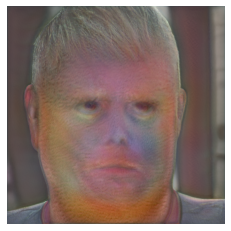

rec loss val: 1137.1727294921875


  1%|          | 122/9768 [06:34<8:43:19,  3.26s/it]

rec loss val: 1115.0152587890625


  1%|▏         | 123/9768 [06:37<8:56:01,  3.33s/it]

rec loss val: 1140.96875


  1%|▏         | 124/9768 [06:40<8:15:27,  3.08s/it]

rec loss val: 1186.434814453125


  1%|▏         | 125/9768 [06:43<8:22:29,  3.13s/it]

rec loss val: 1148.851318359375


  1%|▏         | 126/9768 [06:47<8:37:57,  3.22s/it]

rec loss val: 1289.8209228515625


  1%|▏         | 127/9768 [06:50<8:46:41,  3.28s/it]

rec loss val: 1136.0037841796875


  1%|▏         | 128/9768 [06:53<8:27:11,  3.16s/it]

rec loss val: 999.8764038085938


  1%|▏         | 129/9768 [06:56<8:36:03,  3.21s/it]

rec loss val: 1204.2923583984375


  1%|▏         | 130/9768 [07:00<8:40:18,  3.24s/it]

rec loss val: 1199.3253173828125


  1%|▏         | 131/9768 [07:03<8:42:31,  3.25s/it]

rec loss val: 1138.2025146484375


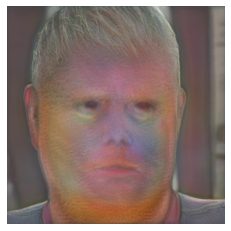

rec loss val: 1138.2025146484375


  1%|▏         | 132/9768 [07:06<8:48:05,  3.29s/it]

rec loss val: 1172.2003173828125


  1%|▏         | 133/9768 [07:09<8:30:18,  3.18s/it]

rec loss val: 1041.0384521484375


  1%|▏         | 134/9768 [07:12<8:38:38,  3.23s/it]

rec loss val: 1260.7313232421875


  1%|▏         | 135/9768 [07:16<8:44:38,  3.27s/it]

rec loss val: 1185.234619140625


  1%|▏         | 136/9768 [07:19<8:44:53,  3.27s/it]

rec loss val: 1148.48876953125


  1%|▏         | 137/9768 [07:22<8:25:42,  3.15s/it]

rec loss val: 1077.0675048828125


  1%|▏         | 138/9768 [07:25<7:56:00,  2.97s/it]

rec loss val: 1023.6906127929688


  1%|▏         | 139/9768 [07:27<7:49:36,  2.93s/it]

rec loss val: 1089.7242431640625


  1%|▏         | 140/9768 [07:31<8:18:38,  3.11s/it]

rec loss val: 1135.520751953125


  1%|▏         | 141/9768 [07:34<8:31:00,  3.18s/it]

rec loss val: 1133.3511962890625


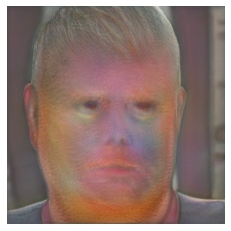

rec loss val: 1133.3511962890625


  1%|▏         | 142/9768 [07:38<8:54:18,  3.33s/it]

rec loss val: 1481.39453125


  1%|▏         | 143/9768 [07:44<10:54:04,  4.08s/it]

rec loss val: 1072.9288330078125


  1%|▏         | 144/9768 [07:47<10:03:05,  3.76s/it]

rec loss val: 968.12255859375


  1%|▏         | 145/9768 [07:50<9:19:12,  3.49s/it] 

rec loss val: 1149.4388427734375


  1%|▏         | 146/9768 [07:53<9:13:05,  3.45s/it]

rec loss val: 1133.349365234375


  2%|▏         | 147/9768 [07:56<9:01:45,  3.38s/it]

rec loss val: 1244.598876953125


  2%|▏         | 148/9768 [07:59<8:53:19,  3.33s/it]

rec loss val: 1173.76171875


  2%|▏         | 149/9768 [08:02<8:31:30,  3.19s/it]

rec loss val: 1147.557373046875


  2%|▏         | 150/9768 [08:05<8:28:50,  3.17s/it]

rec loss val: 1182.0831298828125


  2%|▏         | 151/9768 [08:09<8:39:52,  3.24s/it]

rec loss val: 1235.98681640625


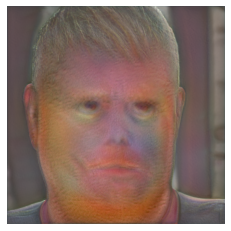

rec loss val: 1235.98681640625


  2%|▏         | 152/9768 [08:12<8:57:00,  3.35s/it]

rec loss val: 1220.548828125


  2%|▏         | 153/9768 [08:15<8:37:03,  3.23s/it]

rec loss val: 1172.7833251953125


  2%|▏         | 154/9768 [08:18<8:21:59,  3.13s/it]

rec loss val: 1049.146728515625


  2%|▏         | 155/9768 [08:21<8:20:59,  3.13s/it]

rec loss val: 1205.5836181640625


  2%|▏         | 156/9768 [08:24<8:10:00,  3.06s/it]

rec loss val: 1092.8232421875


  2%|▏         | 157/9768 [08:27<8:17:45,  3.11s/it]

rec loss val: 1105.5968017578125


  2%|▏         | 158/9768 [08:31<8:43:31,  3.27s/it]

rec loss val: 1230.1788330078125


  2%|▏         | 159/9768 [08:34<8:25:52,  3.16s/it]

rec loss val: 1061.0399169921875


  2%|▏         | 160/9768 [08:37<8:28:24,  3.17s/it]

rec loss val: 1187.963134765625


  2%|▏         | 161/9768 [08:41<8:32:29,  3.20s/it]

rec loss val: 1430.207275390625


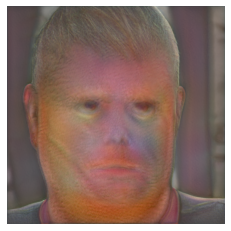

rec loss val: 1430.207275390625


  2%|▏         | 162/9768 [08:44<8:35:49,  3.22s/it]

rec loss val: 1044.403076171875


  2%|▏         | 163/9768 [08:47<8:45:14,  3.28s/it]

rec loss val: 1053.34033203125


  2%|▏         | 164/9768 [08:50<8:41:59,  3.26s/it]

rec loss val: 1053.3253173828125


  2%|▏         | 165/9768 [08:54<8:46:14,  3.29s/it]

rec loss val: 987.5244140625


  2%|▏         | 166/9768 [08:57<8:34:12,  3.21s/it]

rec loss val: 1070.0128173828125


  2%|▏         | 167/9768 [09:00<8:40:18,  3.25s/it]

rec loss val: 1250.689453125


  2%|▏         | 168/9768 [09:03<8:44:46,  3.28s/it]

rec loss val: 1282.1439208984375


  2%|▏         | 169/9768 [09:06<8:29:08,  3.18s/it]

rec loss val: 1185.513427734375


  2%|▏         | 170/9768 [09:10<8:36:35,  3.23s/it]

rec loss val: 1026.822021484375


  2%|▏         | 171/9768 [09:13<8:40:10,  3.25s/it]

rec loss val: 1001.7280883789062


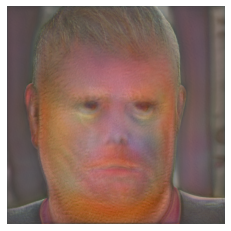

rec loss val: 1001.7280883789062


  2%|▏         | 172/9768 [09:17<9:16:14,  3.48s/it]

rec loss val: 1067.5179443359375


  2%|▏         | 173/9768 [09:22<10:01:00,  3.76s/it]

rec loss val: 1195.3133544921875


  2%|▏         | 174/9768 [09:25<9:32:55,  3.58s/it] 

rec loss val: 1197.7801513671875


  2%|▏         | 175/9768 [09:28<9:00:27,  3.38s/it]

rec loss val: 946.5043334960938


  2%|▏         | 176/9768 [09:31<8:51:05,  3.32s/it]

rec loss val: 1366.2685546875


  2%|▏         | 177/9768 [09:34<8:22:26,  3.14s/it]

rec loss val: 1431.3297119140625


  2%|▏         | 178/9768 [09:37<8:19:09,  3.12s/it]

rec loss val: 1089.11572265625


  2%|▏         | 179/9768 [09:40<8:16:11,  3.10s/it]

rec loss val: 1002.93505859375


  2%|▏         | 180/9768 [09:43<8:25:18,  3.16s/it]

rec loss val: 1079.1444091796875


  2%|▏         | 181/9768 [09:46<8:12:36,  3.08s/it]

rec loss val: 991.8833618164062


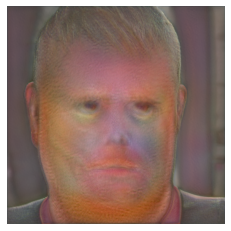

rec loss val: 991.8833618164062


  2%|▏         | 182/9768 [09:50<8:46:57,  3.30s/it]

rec loss val: 1108.32470703125


  2%|▏         | 183/9768 [09:53<8:26:47,  3.17s/it]

rec loss val: 1209.4796142578125


  2%|▏         | 184/9768 [09:56<8:30:36,  3.20s/it]

rec loss val: 1119.5618896484375


  2%|▏         | 185/9768 [09:59<8:17:53,  3.12s/it]

rec loss val: 914.561767578125


  2%|▏         | 186/9768 [10:02<8:25:20,  3.16s/it]

rec loss val: 1084.4766845703125


  2%|▏         | 187/9768 [10:05<8:34:33,  3.22s/it]

rec loss val: 1182.210205078125


  2%|▏         | 188/9768 [10:08<8:28:59,  3.19s/it]

rec loss val: 1128.2095947265625


  2%|▏         | 189/9768 [10:12<8:30:29,  3.20s/it]

rec loss val: 1112.99658203125


  2%|▏         | 190/9768 [10:15<8:38:57,  3.25s/it]

rec loss val: 984.28662109375


  2%|▏         | 191/9768 [10:18<8:40:42,  3.26s/it]

rec loss val: 1115.0577392578125


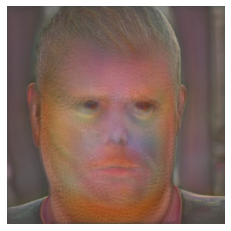

rec loss val: 1115.0577392578125


  2%|▏         | 192/9768 [10:22<8:40:01,  3.26s/it]

rec loss val: 1208.517333984375


  2%|▏         | 193/9768 [10:25<8:45:58,  3.30s/it]

rec loss val: 998.987548828125


  2%|▏         | 194/9768 [10:28<8:40:14,  3.26s/it]

rec loss val: 866.5534057617188


  2%|▏         | 195/9768 [10:31<8:22:14,  3.15s/it]

rec loss val: 1141.84814453125


  2%|▏         | 196/9768 [10:34<8:12:28,  3.09s/it]

rec loss val: 1261.093994140625


  2%|▏         | 197/9768 [10:37<8:07:57,  3.06s/it]

rec loss val: 1129.83642578125


  2%|▏         | 198/9768 [10:39<7:41:52,  2.90s/it]

rec loss val: 1208.267578125


  2%|▏         | 199/9768 [10:43<8:11:02,  3.08s/it]

rec loss val: 1100.5733642578125


  2%|▏         | 200/9768 [10:46<8:20:55,  3.14s/it]

rec loss val: 864.3563232421875


  2%|▏         | 201/9768 [10:49<8:21:36,  3.15s/it]

rec loss val: 1099.9749755859375


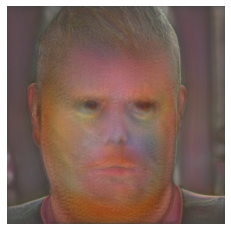

rec loss val: 1099.9749755859375


  2%|▏         | 202/9768 [10:53<8:55:45,  3.36s/it]

rec loss val: 1069.571044921875


  2%|▏         | 203/9768 [10:57<8:51:15,  3.33s/it]

rec loss val: 954.14990234375


  2%|▏         | 204/9768 [11:00<8:51:03,  3.33s/it]

rec loss val: 1232.409912109375


  2%|▏         | 205/9768 [11:02<8:12:19,  3.09s/it]

rec loss val: 1278.0174560546875


  2%|▏         | 206/9768 [11:06<8:16:45,  3.12s/it]

rec loss val: 1169.5540771484375


  2%|▏         | 207/9768 [11:09<8:23:03,  3.16s/it]

rec loss val: 964.2192993164062


  2%|▏         | 208/9768 [11:12<8:35:32,  3.24s/it]

rec loss val: 1161.5103759765625


  2%|▏         | 209/9768 [11:16<8:39:16,  3.26s/it]

rec loss val: 944.2819213867188


  2%|▏         | 210/9768 [11:19<8:44:46,  3.29s/it]

rec loss val: 1014.4379272460938


  2%|▏         | 211/9768 [11:22<8:21:19,  3.15s/it]

rec loss val: 991.6369018554688


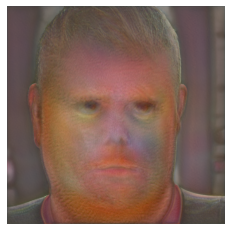

rec loss val: 991.6369018554688


  2%|▏         | 212/9768 [11:26<8:51:20,  3.34s/it]

rec loss val: 987.1652221679688


  2%|▏         | 213/9768 [11:29<8:44:33,  3.29s/it]

rec loss val: 1074.625244140625


  2%|▏         | 214/9768 [11:32<8:43:55,  3.29s/it]

rec loss val: 1075.6502685546875


  2%|▏         | 215/9768 [11:35<8:39:54,  3.27s/it]

rec loss val: 1026.1968994140625


  2%|▏         | 216/9768 [11:38<8:35:42,  3.24s/it]

rec loss val: 1152.422607421875


  2%|▏         | 217/9768 [11:42<8:44:44,  3.30s/it]

rec loss val: 1191.0350341796875


  2%|▏         | 218/9768 [11:45<8:41:40,  3.28s/it]

rec loss val: 1005.3427734375


  2%|▏         | 219/9768 [11:48<8:43:19,  3.29s/it]

rec loss val: 1075.6517333984375


  2%|▏         | 220/9768 [11:52<8:52:10,  3.34s/it]

rec loss val: 1105.333251953125


  2%|▏         | 221/9768 [11:55<8:58:15,  3.38s/it]

rec loss val: 1121.5985107421875


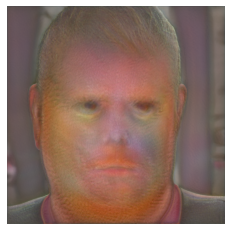

rec loss val: 1121.5985107421875


  2%|▏         | 222/9768 [11:59<9:26:56,  3.56s/it]

rec loss val: 1089.9952392578125


  2%|▏         | 223/9768 [12:02<8:41:53,  3.28s/it]

rec loss val: 1004.1122436523438


  2%|▏         | 224/9768 [12:05<8:54:25,  3.36s/it]

rec loss val: 1117.4686279296875


  2%|▏         | 225/9768 [12:09<8:53:43,  3.36s/it]

rec loss val: 1013.6491088867188


  2%|▏         | 226/9768 [12:12<8:53:17,  3.35s/it]

rec loss val: 1283.7569580078125


  2%|▏         | 227/9768 [12:15<8:49:07,  3.33s/it]

rec loss val: 1151.599609375


  2%|▏         | 228/9768 [12:19<8:45:28,  3.30s/it]

rec loss val: 1392.2159423828125


  2%|▏         | 229/9768 [12:22<8:24:07,  3.17s/it]

rec loss val: 1274.1204833984375


  2%|▏         | 230/9768 [12:25<8:17:46,  3.13s/it]

rec loss val: 1233.4544677734375


  2%|▏         | 231/9768 [12:27<8:03:54,  3.04s/it]

rec loss val: 1202.200927734375


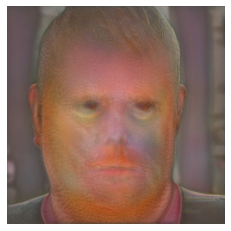

rec loss val: 1202.200927734375


  2%|▏         | 232/9768 [12:31<8:41:33,  3.28s/it]

rec loss val: 986.0494384765625


  2%|▏         | 233/9768 [12:34<8:38:01,  3.26s/it]

rec loss val: 1068.4119873046875


  2%|▏         | 234/9768 [12:38<8:42:11,  3.29s/it]

rec loss val: 1228.335205078125


  2%|▏         | 235/9768 [12:41<8:34:09,  3.24s/it]

rec loss val: 1067.7684326171875


  2%|▏         | 236/9768 [12:44<8:38:36,  3.26s/it]

rec loss val: 1084.656982421875


  2%|▏         | 237/9768 [12:47<8:36:34,  3.25s/it]

rec loss val: 1295.73388671875


  2%|▏         | 238/9768 [12:51<8:37:21,  3.26s/it]

rec loss val: 1154.4095458984375


  2%|▏         | 239/9768 [12:54<8:19:24,  3.14s/it]

rec loss val: 1002.7896728515625


  2%|▏         | 240/9768 [12:57<8:24:56,  3.18s/it]

rec loss val: 1028.7901611328125


  2%|▏         | 241/9768 [13:00<8:28:12,  3.20s/it]

rec loss val: 1075.839111328125


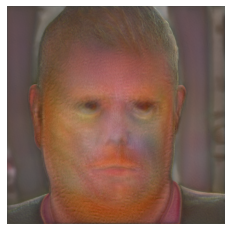

rec loss val: 1075.839111328125


  2%|▏         | 242/9768 [13:04<9:01:39,  3.41s/it]

rec loss val: 866.6793823242188


  2%|▏         | 243/9768 [13:07<8:53:25,  3.36s/it]

rec loss val: 1108.802734375


  2%|▏         | 244/9768 [13:11<8:55:12,  3.37s/it]

rec loss val: 977.4581298828125


  3%|▎         | 245/9768 [13:13<8:14:39,  3.12s/it]

rec loss val: 1035.707763671875


  3%|▎         | 246/9768 [13:16<8:11:58,  3.10s/it]

rec loss val: 1145.6873779296875


  3%|▎         | 247/9768 [13:20<8:19:48,  3.15s/it]

rec loss val: 1093.6844482421875


  3%|▎         | 248/9768 [13:23<8:24:25,  3.18s/it]

rec loss val: 1025.683349609375


  3%|▎         | 249/9768 [13:26<8:11:56,  3.10s/it]

rec loss val: 1174.72802734375


  3%|▎         | 250/9768 [13:29<8:09:56,  3.09s/it]

rec loss val: 1107.719482421875


  3%|▎         | 251/9768 [13:32<8:20:38,  3.16s/it]

rec loss val: 1158.7821044921875


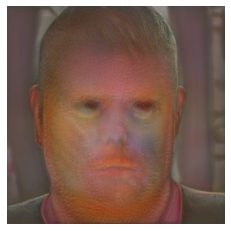

rec loss val: 1158.7821044921875


  3%|▎         | 252/9768 [13:36<8:44:43,  3.31s/it]

rec loss val: 966.9524536132812


  3%|▎         | 253/9768 [13:39<8:45:17,  3.31s/it]

rec loss val: 1133.7547607421875


  3%|▎         | 254/9768 [13:42<8:41:21,  3.29s/it]

rec loss val: 1099.7486572265625


  3%|▎         | 255/9768 [13:46<8:42:18,  3.29s/it]

rec loss val: 1038.1517333984375


  3%|▎         | 256/9768 [13:48<8:16:31,  3.13s/it]

rec loss val: 1011.6153564453125


  3%|▎         | 257/9768 [13:52<8:17:50,  3.14s/it]

rec loss val: 1345.636474609375


  3%|▎         | 258/9768 [13:55<8:22:01,  3.17s/it]

rec loss val: 955.8042602539062


  3%|▎         | 259/9768 [13:58<8:32:28,  3.23s/it]

rec loss val: 1134.59228515625


  3%|▎         | 260/9768 [14:01<8:31:38,  3.23s/it]

rec loss val: 917.8672485351562


  3%|▎         | 261/9768 [14:05<8:39:42,  3.28s/it]

rec loss val: 1270.6239013671875


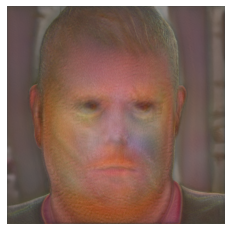

rec loss val: 1270.6239013671875


  3%|▎         | 262/9768 [14:08<8:38:27,  3.27s/it]

rec loss val: 1184.537841796875


  3%|▎         | 263/9768 [14:12<8:55:03,  3.38s/it]

rec loss val: 1034.9813232421875


  3%|▎         | 264/9768 [14:15<8:52:37,  3.36s/it]

rec loss val: 1269.849609375


  3%|▎         | 265/9768 [14:18<8:35:42,  3.26s/it]

rec loss val: 1126.8441162109375


  3%|▎         | 266/9768 [14:21<8:39:23,  3.28s/it]

rec loss val: 1055.302001953125


  3%|▎         | 267/9768 [14:25<8:36:15,  3.26s/it]

rec loss val: 1001.0335693359375


  3%|▎         | 268/9768 [14:27<7:59:47,  3.03s/it]

rec loss val: 1220.060546875


  3%|▎         | 269/9768 [14:30<8:15:46,  3.13s/it]

rec loss val: 927.8797607421875


  3%|▎         | 270/9768 [14:33<8:08:22,  3.09s/it]

rec loss val: 1076.3543701171875


  3%|▎         | 271/9768 [14:36<7:50:57,  2.98s/it]

rec loss val: 1079.537109375


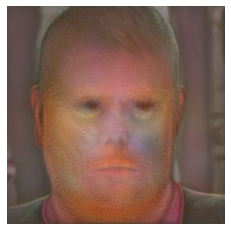

rec loss val: 1079.537109375


  3%|▎         | 272/9768 [14:40<8:23:59,  3.18s/it]

rec loss val: 1068.707763671875


  3%|▎         | 273/9768 [14:43<8:35:54,  3.26s/it]

rec loss val: 1095.467529296875


  3%|▎         | 274/9768 [14:46<8:04:03,  3.06s/it]

rec loss val: 861.6685180664062


  3%|▎         | 275/9768 [14:49<8:18:55,  3.15s/it]

rec loss val: 977.4848022460938


  3%|▎         | 276/9768 [14:53<8:30:05,  3.22s/it]

rec loss val: 1173.186279296875


  3%|▎         | 277/9768 [14:56<8:29:36,  3.22s/it]

rec loss val: 1102.5723876953125


  3%|▎         | 278/9768 [14:59<8:12:41,  3.12s/it]

rec loss val: 994.0316162109375


  3%|▎         | 279/9768 [15:02<8:24:55,  3.19s/it]

rec loss val: 1277.6458740234375


  3%|▎         | 280/9768 [15:05<8:30:04,  3.23s/it]

rec loss val: 1031.796875


  3%|▎         | 281/9768 [15:08<8:13:09,  3.12s/it]

rec loss val: 1050.6685791015625


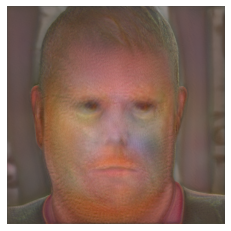

rec loss val: 1050.6685791015625


  3%|▎         | 282/9768 [15:12<8:46:32,  3.33s/it]

rec loss val: 1134.1729736328125


  3%|▎         | 283/9768 [15:15<8:46:18,  3.33s/it]

rec loss val: 829.8397216796875


  3%|▎         | 284/9768 [15:19<8:53:23,  3.37s/it]

rec loss val: 1044.0640869140625


  3%|▎         | 285/9768 [15:22<8:53:42,  3.38s/it]

rec loss val: 1342.64697265625


  3%|▎         | 286/9768 [15:25<8:45:57,  3.33s/it]

rec loss val: 836.487548828125


  3%|▎         | 287/9768 [15:29<8:37:33,  3.28s/it]

rec loss val: 1093.4134521484375


  3%|▎         | 288/9768 [15:32<8:42:51,  3.31s/it]

rec loss val: 1249.441162109375


  3%|▎         | 289/9768 [15:35<8:32:29,  3.24s/it]

rec loss val: 1232.042724609375


  3%|▎         | 290/9768 [15:38<8:31:13,  3.24s/it]

rec loss val: 1130.3721923828125


  3%|▎         | 291/9768 [15:41<8:18:57,  3.16s/it]

rec loss val: 979.509765625


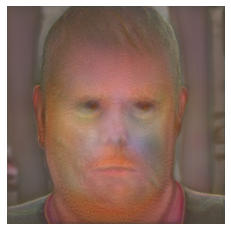

rec loss val: 979.509765625


  3%|▎         | 292/9768 [15:45<8:29:33,  3.23s/it]

rec loss val: 1049.9881591796875


  3%|▎         | 293/9768 [15:48<8:27:17,  3.21s/it]

rec loss val: 1170.87890625


  3%|▎         | 294/9768 [15:50<7:54:21,  3.00s/it]

rec loss val: 1154.6131591796875


  3%|▎         | 295/9768 [15:54<8:06:27,  3.08s/it]

rec loss val: 1318.7493896484375


  3%|▎         | 296/9768 [15:56<7:57:12,  3.02s/it]

rec loss val: 994.3952026367188


  3%|▎         | 297/9768 [16:00<8:07:19,  3.09s/it]

rec loss val: 1193.4998779296875


  3%|▎         | 298/9768 [16:03<8:14:19,  3.13s/it]

rec loss val: 1181.6944580078125


  3%|▎         | 299/9768 [16:06<8:26:15,  3.21s/it]

rec loss val: 1059.106201171875


  3%|▎         | 300/9768 [16:10<8:27:50,  3.22s/it]

rec loss val: 995.4629516601562


  3%|▎         | 301/9768 [16:13<8:35:43,  3.27s/it]

rec loss val: 1330.06689453125


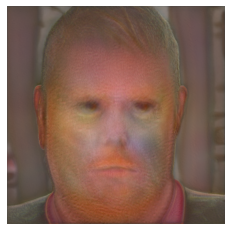

rec loss val: 1330.06689453125


  3%|▎         | 302/9768 [16:17<8:58:45,  3.41s/it]

rec loss val: 875.96630859375


  3%|▎         | 303/9768 [16:20<8:47:09,  3.34s/it]

rec loss val: 997.5390625


In [ ]:
same_images = True
use_descrimantive_loss = False
with tqdm(total=config['epochs'] * len(train_loader)) as pbar:
    for epoch in range(config['epochs']):
        for idx, data in enumerate(train_loader):
            torch.cuda.empty_cache()
            id_images, attr_images, ws = data

            id_images = id_images[0].cuda()
            attr_images = attr_images[0].cuda()
            ws = ws.cuda()

            with torch.no_grad():
                id_vec = torch.squeeze(id_encoder(id_transform(id_images)))
                attr_vec = torch.squeeze(attr_encoder(attr_transform(attr_images)))
                try:
                    encoded_vec = torch.cat((id_vec,attr_vec), dim=1)
                except:
                    continue

            fake_data = mlp(encoded_vec)

            if use_descrimantive_loss and idx % 2 == 0:
                error_real, error_fake, prediction_real, prediction_fake, g_error, g_pred = trainer.adversarial_train_step(ws, fake_data, False)
                D_error_real_train.append(error_real.cpu().detach())
                D_error_fake_train.append(error_fake.cpu().detach())
                D_prediction_real_train.append(prediction_real.cpu().detach())
                D_prediction_fake_train.append(prediction_fake.cpu().detach())
                G_error_train.append(g_error.cpu().detach())
                G_pred_train.append(g_pred.cpu().detach())
            else:
                id_loss_val, rec_loss_val, landmark_loss_val, total_error = trainer.non_adversarial_train_step(id_vec, attr_images, fake_data, True, False, False)
                print(f'rec loss val: {rec_loss_val}')

            pbar.update(1)
            if idx % 10 == 0 and idx != 0:
                with torch.no_grad():
                  if run_in_colab:
                    plot_single_w_image(mlp(non_cycled_test_vec)[0], generator)
                    print(f'rec loss val: {rec_loss_val}')

                  wandb.log({'D_error_real_train': mean(D_error_real_train), 'D_error_fake_train': mean(D_error_fake_train),
                            'D_prediction_real_train': mean(D_prediction_real_train), 'D_prediction_fake_train': mean(D_prediction_fake_train),
                            'G_error_train': mean(G_error_train), 'G_pred_train': mean(G_pred_train),
                            'id_loss_train': mean(id_loss_train), 'rec_loss_train': mean(rec_loss_train),
                            'landmark_loss_train' : mean(landmark_loss_train), 'total_error_train': mean(total_error_train)})
                  D_error_real_train = []
                  D_error_fake_train = []           
                  D_prediction_real_train = []
                  D_prediction_fake_train = []          
                  G_error_train = []
                  G_pred_train = []
                  id_loss_train = []
                  rec_loss_train = []
                  landmark_loss_train = []
                  total_error_train = []
                    
          if idx % 100 == 0 and idx != 0:
              id_generated_image = get_w_image(mlp(non_cycled_test_vec)[0], generator)
              id_and_attr_generated_image = get_w_image(mlp(cycled_test_vec)[0], generator)
              wandb.log({"ID_Train_Images": [wandb.Image(id_generated_image, caption=f"generated_image{idx}")]})
              wandb.log({"Cycle_Train_Images": [wandb.Image(id_and_attr_generated_image, caption=f"generated_image{idx}")]})
              torch.save(mlp, f'{MODELS_DIR}{idx}_{time.time()}_{int(total_error)}.pt')
     